# ECSE415 - Into to Computer Vision
## Assignment 3
### Alexander Harris - 260688155

## 2 - Stereo Vision
### 2.1 - Depth Estimation from Stereo Images

In [1]:
import cv2
import numpy as np
import sys
import re
import math
from struct import *
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img

In [8]:
def plotFigures(images):
    """
    Plots images from list in grid.
    
    images: list of images
    title: title for each subplot
    params: specific arguments to add to title
    """
    grid_len = math.ceil(math.sqrt(len(images)))
    
    plt.figure(figsize=(30, 30))
    for i, image in enumerate(images):
        params_str = image['params']
        title = image['title']
        plt.subplot(grid_len, grid_len, i+1), plt.imshow(image['image'], 'gray')
        plt.title('{} - {}'.format(title, params_str)), plt.axis('off')
    plt.show()

In [9]:
imgL = cv2.imread('./im0.png', 0)
imgR = cv2.imread('./im1.png', 0)

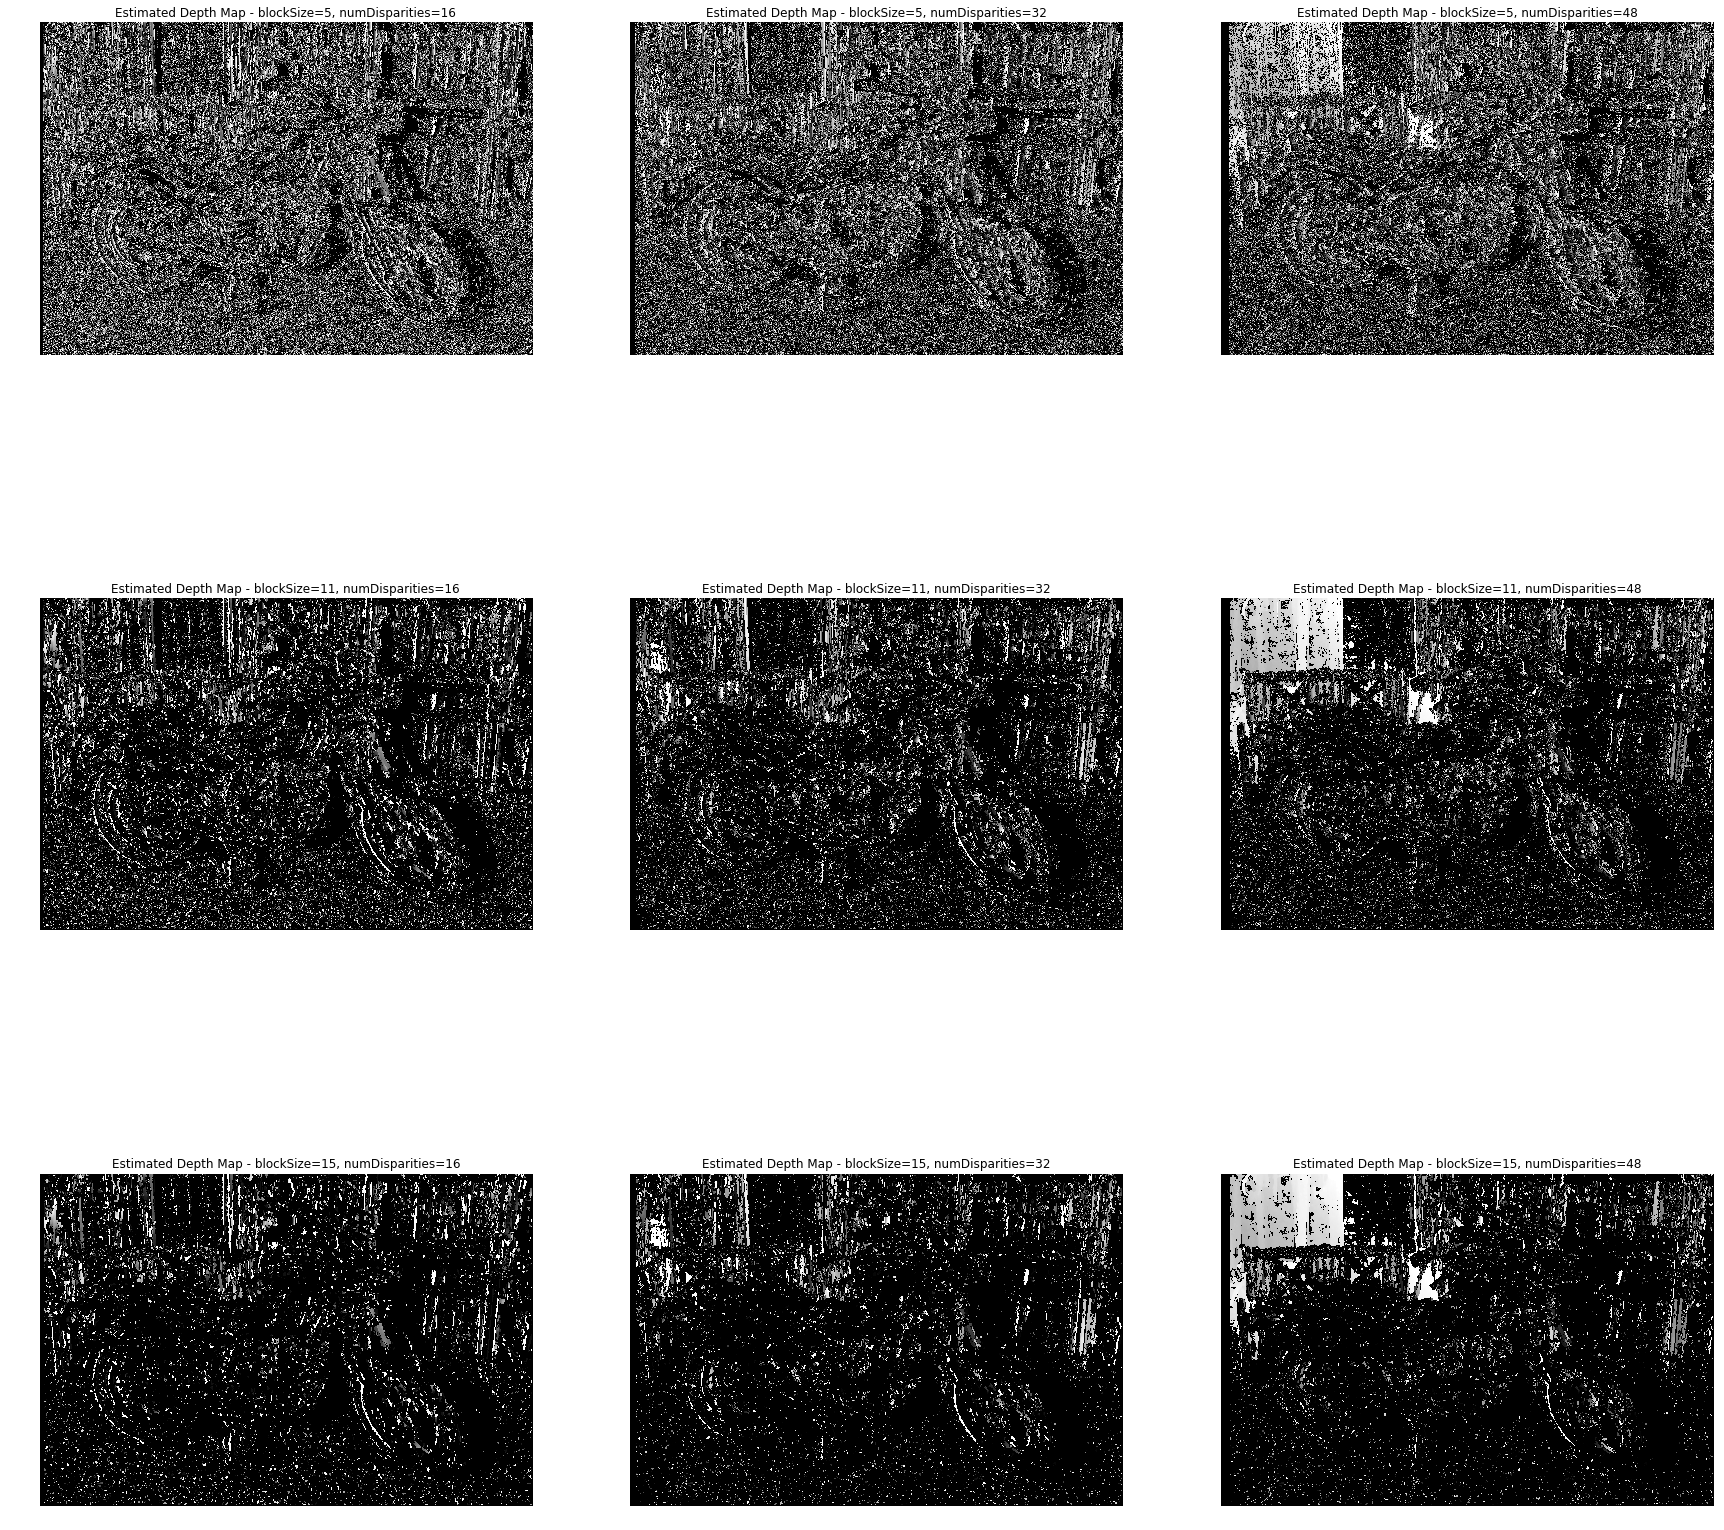

In [10]:
block_size = [5, 11, 15]
num_disp = [16, 32, 48]

images = []

for size in block_size:
    for disp in num_disp:
        stereo = cv2.StereoBM_create(numDisparities=disp, blockSize=size)
        depth = stereo.compute(imgL, imgR)
        res = {'image': depth, 'title': 'Estimated Depth Map', 'params': 'blockSize={}, numDisparities={}'.format(size, disp)}
        images.append(res)
        
plotFigures(images)

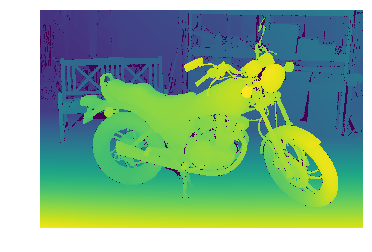

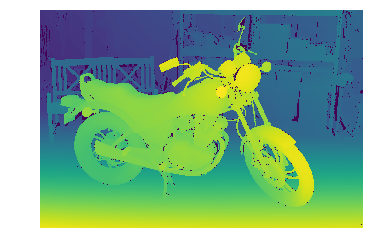

In [5]:
depth_img0 = read_pfm('disp0.pfm')
depth_img1 = read_pfm('disp1.pfm')

depth_img0[depth_img0 == np.inf] = 0
depth_img1[depth_img1 == np.inf] = 0
plt.imshow(depth_img0), plt.axis('off')
plt.show()
plt.imshow(depth_img1), plt.axis('off')
plt.show()